# 8-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)
print(tf.__version__)

1.3.3
0.5.2
4.1.2
2.6.0


## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # train data
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    # test data
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 학습 데이터에서 가장 많이 등장하는 단어를 선택하여 단어 집합(vocabulary) 구성
    words = np.concatenate(X_train).tolist() # words에는 학습 데이터에 등장한 모든 단어가 포함된 리스트가 저장
    counter = Counter(words) # Counter 클래스를 사용하여 words 리스트 내의 각 단어의 빈도수를 계산
    counter = counter.most_common(10000-4) # 빈도수가 가장 높은 단어부터 내림차순으로 정렬된 리스트를 생성, -4를 하는 이유는 이전에 4개의 예약어를 추가했기 때문
    vocab = ['', '', '', ''] + [key for key, _ in counter] # 처음 4개의 요소가 빈 문자열('')로 초기화 그리고 이어서 상위 단어들이 추가
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리
    
    # 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2 # unknown
    word_to_index["<UNUSED>"] = 3

    # 주어진 단어 리스트(wordlist)를 단어 인덱스 리스트로 변환하는 역할
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# pre padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 첫 번째 모델 CNN

In [39]:
def cnn_model(embedding_matrix, maxlen, vocab_size=10000, word_vector_dim=100):
    '''
    embedding_matrix: 사전 학습된 임베딩 레이어 (없으면 0)
    maxlen: 문장의 최대 길이
    vocab_size: 어휘 사전의 크기입니다(단어 개수)
    word_vector_dim: 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
    '''

    # model 설계
    model = tf.keras.Sequential()
    
    if type(embedding_matrix) != int:
        model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=maxlen, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
    else:
        model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1 dim 입니다.
    
    print(model.summary())
    
    return model

In [8]:
model_cnn = cnn_model(0,maxlen)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 두 번째 모델 RNN

In [11]:
def rnn_model(embedding_matrix, maxlen,vocab_size=10000, word_vector_dim=100):
    '''
    embedding_matrix: 사전 학습된 임베딩 레이어 (없으면 0)
    maxlen: 문장의 최대 길이
    vocab_size: 어휘 사전의 크기입니다(단어 개수)
    word_vector_dim: 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
    '''

    # model 설계
    model = tf.keras.Sequential()
    
    if embedding_matrix == True:
        model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=maxlen, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
    else:
        model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

    model.add(tf.keras.layers.SimpleRNN(32))  # RNN 레이어
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1 dim 입니다.
        
    print(model.summary())
    
    return model

In [12]:
model_rnn = rnn_model(0, maxlen)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,004,529
Trainable params: 1,004,529
Non-trainable params: 0
_________________________________________________________________
None


### 세 번째 모델 GlobalMaxPooling

In [13]:
def globalmax_model(embedding_matrix, maxlen, vocab_size=10000, word_vector_dim=100):
    '''
    embedding_matrix: 사전 학습된 임베딩 레이어 (없으면 0)
    maxlen: 문장의 최대 길이
    vocab_size: 어휘 사전의 크기입니다(단어 개수)
    word_vector_dim: 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
    '''

    # model 설계
    model = tf.keras.Sequential()
    
    if embedding_matrix == True:
        model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=maxlen, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
    else:
        model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

    model.add(tf.keras.layers.GlobalMaxPooling1D())  # GlobalMaxPooling 레이어
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1 dim 입니다.
        
    print(model.summary())
    
    return model

In [20]:
model_gm = globalmax_model(0,maxlen)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________
None


## 5) 모델 훈련 개시

In [15]:
# validation set 20%로 분리
split_ratio = 0.2
split_index = int(len(X_train) * split_ratio)

x_val = X_train[:split_index]   
y_val = y_train[:split_index]

# validation set을 제외한 나머지 80%
partial_x_train = X_train[split_index:]  
partial_y_train = y_train[split_index:]

print("partial_x_train size: ", partial_x_train.shape)
print("partial_y_train size: ", partial_y_train.shape)

partial_x_train size:  (116946, 41)
partial_y_train size:  (116946,)


### CNN 훈련 및 결과

In [16]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 7ms/step - loss: 0.4570 - accuracy: 0.7788 - val_loss: 0.3427 - val_accuracy: 0.8506
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3093 - accuracy: 0.8702 - val_loss: 0.3286 - val_accuracy: 0.8588
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2590 - accuracy: 0.8952 - val_loss: 0.3301 - val_accuracy: 0.8611
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2019 - accuracy: 0.9238 - val_loss: 0.3571 - val_accuracy: 0.8545
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1411 - accuracy: 0.9503 - val_loss: 0.4158 - val_accuracy: 0.8486
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.0934 - accuracy: 0.9689 - val_loss: 0.4868 - val_accuracy: 0.8457
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.0627 - accuracy: 0.9808 - val_loss: 0.5695 - val_accuracy: 0.8424
Epoch 

In [17]:
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 1.1517 - accuracy: 0.8277
[1.1517093181610107, 0.827715277671814]


### RNN 훈련 및 결과

In [18]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 11s 42ms/step - loss: 0.4287 - accuracy: 0.8050 - val_loss: 0.3530 - val_accuracy: 0.8467
Epoch 2/20
229/229 [==============================] - 9s 40ms/step - loss: 0.3237 - accuracy: 0.8643 - val_loss: 0.3491 - val_accuracy: 0.8509
Epoch 3/20
229/229 [==============================] - 9s 41ms/step - loss: 0.2809 - accuracy: 0.8866 - val_loss: 0.3683 - val_accuracy: 0.8413
Epoch 4/20
229/229 [==============================] - 9s 41ms/step - loss: 0.2281 - accuracy: 0.9131 - val_loss: 0.4067 - val_accuracy: 0.8346
Epoch 5/20
229/229 [==============================] - 9s 41ms/step - loss: 0.1772 - accuracy: 0.9354 - val_loss: 0.4507 - val_accuracy: 0.8268
Epoch 6/20
229/229 [==============================] - 9s 41ms/step - loss: 0.1405 - accuracy: 0.9505 - val_loss: 0.5019 - val_accuracy: 0.8230
Epoch 7/20
229/229 [==============================] - 9s 41ms/step - loss: 0.1135 - accuracy: 0.9604 - val_loss: 0.5819 - val_accuracy: 0.818

In [21]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 7s - loss: 1.0890 - accuracy: 0.8029
[1.088998556137085, 0.8028764724731445]


### GlobalMaxPooling 훈련 및 결과

In [23]:
model_gm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gm = model_gm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.4964 - accuracy: 0.7977 - val_loss: 0.3576 - val_accuracy: 0.8420
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3257 - accuracy: 0.8619 - val_loss: 0.3371 - val_accuracy: 0.8528
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2798 - accuracy: 0.8840 - val_loss: 0.3387 - val_accuracy: 0.8555
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2441 - accuracy: 0.9024 - val_loss: 0.3475 - val_accuracy: 0.8553
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2107 - accuracy: 0.9189 - val_loss: 0.3641 - val_accuracy: 0.8535
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.1774 - accuracy: 0.9349 - val_loss: 0.3859 - val_accuracy: 0.8501
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1459 - accuracy: 0.9497 - val_loss: 0.4137 - val_accuracy: 0.8486
Epoch 

In [24]:
results_gm = model_gm.evaluate(X_test,  y_test, verbose=2)

print(results_gm)

1537/1537 - 2s - loss: 0.8565 - accuracy: 0.8265
[0.8565140962600708, 0.8264540433883667]


## 6) Loss, Accuracy 그래프 시각화

In [25]:
history_dict = history_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [27]:
def result_plot(eval_name, train_eval, val_eval, epochs):
    '''
    eval_name: 'accuracy', 'loss'
    '''
    # name
    train_label = 'Training ' + eval_name
    val_label = 'Training ' + eval_name
    plot_title = 'Training and validation ' + eval_name
    
    # draw
    plt.plot(epochs, train_eval, 'bo', label=train_label) # "bo"는 "파란색 점"입니다
    plt.plot(epochs, val_eval, 'b', label=val_label) # b는 "파란 실선"입니다
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel(eval_name)
    plt.legend()

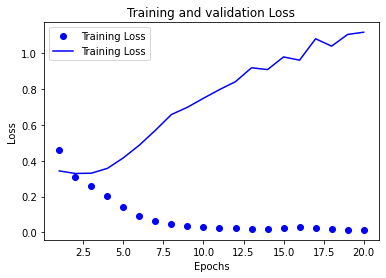

In [28]:
result_plot('Loss', loss, val_loss, epochs)

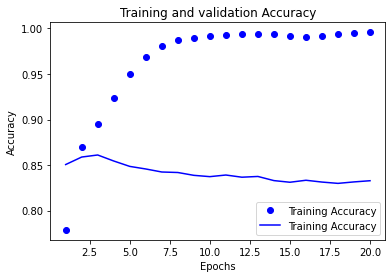

In [29]:
result_plot('Accuracy', acc, val_acc, epochs)

## 7) 학습된 Embedding 레이어 분석

In [30]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [31]:
import os

vocab_size = weights.shape[0]
word_vector_dim = weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/workplace/exploration/ex04/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.04407321, -0.00319362, -0.01487116, -0.03827733, -0.04826949,
       -0.01155907, -0.03736287, -0.00327495,  0.01635257, -0.00869817,
        0.01792267,  0.01461221,  0.03230265, -0.03731353,  0.00613331,
        0.00729008,  0.01190798, -0.01070349,  0.02402124, -0.01754151,
       -0.01943004,  0.03494206, -0.01110737,  0.01978768, -0.01296445,
       -0.03251396, -0.00934353,  0.01701826, -0.03513157, -0.00935203,
        0.0285528 , -0.03786641,  0.00513808,  0.02759087,  0.01476062,
        0.02616345,  0.01161699,  0.01302848, -0.00469214, -0.03158619,
        0.04872098, -0.03613473,  0.00461067,  0.04520884,  0.03750436,
       -0.01241492, -0.03041358, -0.00982108,  0.02787762, -0.03322228,
       -0.01774908, -0.03788294, -0.02623783,  0.01654999, -0.00916364,
       -0.0169176 , -0.00765149, -0.02664504,  0.03672692,  0.04365844,
        0.00363175,  0.01682774,  0.03252282,  0.00603796, -0.01853387,
        0.03066956, -0.03738133, -0.04094013, -0.00096538,  0.01

In [33]:
word_vectors.similar_by_word("사랑")

[('동일', 0.32821688055992126),
 ('번지르르', 0.3277997076511383),
 ('지수', 0.3262002170085907),
 ('한단', 0.3242741525173187),
 ('텅', 0.3176712989807129),
 ('PD', 0.31380462646484375),
 ('-_', 0.31281813979148865),
 ('대회', 0.312574565410614),
 ('파이터', 0.30854105949401855),
 ('SM', 0.304198682308197)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = '/aiffel/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']
vector.shape

(100,)

In [44]:
# '사랑'과 유사한 단어
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [40]:
from tensorflow.keras.initializers import Constant

model = cnn_model(embedding_matrix,maxlen,vocab_size,word_vector_dim)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [41]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 7ms/step - loss: 0.6039 - accuracy: 0.6543 - val_loss: 0.5095 - val_accuracy: 0.7524
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4546 - accuracy: 0.7879 - val_loss: 0.4250 - val_accuracy: 0.8066
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3921 - accuracy: 0.8245 - val_loss: 0.4021 - val_accuracy: 0.8190
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3548 - accuracy: 0.8451 - val_loss: 0.3724 - val_accuracy: 0.8361
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3255 - accuracy: 0.8601 - val_loss: 0.3633 - val_accuracy: 0.8404
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3053 - accuracy: 0.8703 - val_loss: 0.3657 - val_accuracy: 0.8382
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2881 - accuracy: 0.8784 - val_loss: 0.3644 - val_accuracy: 0.8450
Epoch 

In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5100 - accuracy: 0.8330
[0.5100432634353638, 0.832963764667511]


# 회고
텍스트 분석에서 임베딩 레이어의 중요성을 배웠다. pre trained model의 사용방법과 성능향상을 경험했다. 여전히 성능을 높이기 위한 방법이 고민이다.